In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
import numpy as np
import pandas as pd 
import os
from PIL import Image 
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt 

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

torch.manual_seed(45)
np.random.seed(45)

cuda:0


In [53]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
props = torch.cuda.get_device_properties(0)
print(props)

1
NVIDIA GeForce RTX 4060
_CudaDeviceProperties(name='NVIDIA GeForce RTX 4060', major=8, minor=9, total_memory=7796MB, multi_processor_count=24, uuid=089b23a4-ea2c-397c-2e09-e0be5e7421ac, pci_bus_id=1, pci_device_id=0, pci_domain_id=0, L2_cache_size=24MB)


In [54]:
# Custom Dataset class modeled after Pytorch dataset. Created to avoid 'class-per-folder' 
# organization that is required by standard pytorch datasets.

# BLAME: Zebulon Mcknight *** 

class DogBreedDataset(Dataset):
    # __init__ receives a pandas dataframe of form ('id')('breed'), a directory
    # containing images, a dict of the form ('breed')(int label), and an optional
    # transform pipeline. 
    def __init__(self, label_df, img_dir, labels, transform=None): 
        self.labels_df = label_df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = labels

    # __len__ simply returns the number of samples in a dataset
    def __len__(self): 
        return len(self.labels_df)
    
    # __getitem__ takes in an index representing an entry in the dataset, it returns the img 
    # and proper class label associated with that index 
    def __getitem__(self, index): 
        row = self.labels_df.iloc[index]
        path = os.path.join(self.img_dir, row["id"]+ ".jpg")
        img = Image.open(path)
        img = img.convert("RGB")

        if self.transform: 
            img = self.transform(img)

        label = self.classes[row['breed']]

        return img, label

In [55]:
# Reading in labels for each image 
# BLAME: Minh Cao *** 
labels = pd.read_csv("data/labels.csv")
breeds = labels['breed'].unique() 

# Dict mapping 'breed' to index, model will operate on integers and we will convert back to breeds 
classes = {b: i for i, b in enumerate(breeds)}

In [56]:
# Data Transformers 

# BLAME: Zebulon Mcknight ***

train_transforms = transforms.Compose([
    transforms.Resize((224,224)), # pytorch expects 224x224 sized images

    # These transformations are standard for introducing more randomness into the training set. 
    # These transformations haven't been tested and perfected individually, but instead
    # come as standard recommended parts of the pipeline for reducing overfitting and promoting
    # generalization 
    transforms.RandomHorizontalFlip(), 
    transforms.RandomResizedCrop(224, scale = (0.8, 1.0)),
    transforms.RandomRotation(15), 
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3), 
    transforms.ToTensor(), 

    # Here we normalize RGB values to the mean and standard deviation of the ImageNet dataset, 
    # the set that our pretrained model was trained on. 
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # pytorch expects 224x224 sized images
    transforms.ToTensor(),

    # Here we normalize RGB values to the mean and standard deviation of the ImageNet dataset, 
    # the set that our pretrained model was trained on. 
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [57]:
# Load all data into a dataset 
# BLAME: Minh Cao *** 
dataset = DogBreedDataset(labels, "data/train", classes, train_transforms)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [58]:
test = DogBreedDataset(labels, "data/test", classes, val_transforms)
test_df = dataset.labels_df

In [59]:
num_classes = len(dataset.classes)

In [60]:
# Split data into training and validation sets stratified by class membership 
# BLAME: Viwesh Gupta
train_df, val_df = train_test_split(dataset.labels_df, 
                                    test_size=0.2, 
                                    stratify=dataset.labels_df['breed'])

train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)

In [61]:
# Load split data into independent training and validation datasets
# BLAME: Kyle Bomar ***
 
train_dataset = DogBreedDataset(
    label_df=train_df,
    img_dir ='data/train',
    labels = classes,
    transform=train_transforms
)

val_dataset = DogBreedDataset(
    label_df = val_df,
    img_dir ='data/train',
    labels = classes, 
    transform=val_transforms
)

test_dataset = DogBreedDataset(
    label_df = test_df, 
    img_dir ='data/test', 
    labels = classes, 
    transform=val_transforms
)

In [62]:
# Define our dataloaders for training and validation
# BLAME: Kyle Bomar ***

train_loader = DataLoader(
    # these variable primarily affect efficiency at fetching data
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=8, # when running on windows num_worker must equal zero, there is a well known pytorch bug forcing this 
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False, 
    num_workers=8,
    pin_memory=False
)


In [63]:
# Test if the dataset itself is working
# BLAME: Viwesh Gupta ***
for i in range(3):
    try:
        x, y = train_dataset[i]
        print(f"Item {i}: Image shape = {x.shape}, Label = {y}")
    except Exception as e:
        print(f"Error at index {i}: {e}")


Item 0: Image shape = torch.Size([3, 224, 224]), Label = 68
Item 1: Image shape = torch.Size([3, 224, 224]), Label = 79
Item 2: Image shape = torch.Size([3, 224, 224]), Label = 14


In [74]:
# DEFINING MODEL SPECIFICATIONS

# BLAME: Zebulon Mcknight and Minh Cao***

# This line represents our model. For this implementation we are 
# using resnet18 with weights pretrained on ImageNetV1. This is an
# industry standard Convolutional Neural Network designed for image
# classification. 
cnn = models.resnet18(weights="IMAGENET1K_V1")

# Here we freeze all but the last layer of the cnn, this lets us
# start from a good place for image classification but lets us
# design our own final layer for predictions. 
for param in cnn.parameters(): 
    param.requires_grad = False

# Our final layer. This resembles a 2 layer MLP (multi layer perceptron)
# That maps the hundreds or thousands of features present in the CNN 
# to the 120 outputs that we need to map to class probabilities. This layer is 
# the only layer we are training in our training loop. 
cnn.fc = nn.Sequential(
    nn.Linear(cnn.fc.in_features, 256), 
    nn.ReLU(), 
    nn.Dropout(0.5), # Using dropout will hurt training performance, but decrease overfitting 
    nn.Linear(256, num_classes)
)

cnn=cnn.to(device)
print(cnn)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [75]:
criterion = nn.CrossEntropyLoss() # we'll be using CrossEntropy loss 
# This is our optimizer, ADAM is similar to an improved verison of stochastic 
# gradient descent designed specifically for deep learning
optimizer = optim.Adam(cnn.fc.parameters(), lr=1e-3, weight_decay=1e-4) 

In [76]:
# TRAINING LOOP 

# BLAME: Zebulon Mcknight ***

# Our training function takes in a reference to our model, our training and validation
# loaders, a loss function, an optimizer, and a number of epochs to train for 
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, unfreeze=False, schedule=None): 
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs): 
        if unfreeze == True and epoch in schedule: 
            unfreeze_layer(model, schedule[epoch])
            print(f"Unfroze {schedule[epoch]}")


        model.train()

        # We will track loss and accuracy for each epoch 
        running_loss = 0.0
        running_corrects = 0

        # each epoch is broken into batches of 64 images
        for inputs, labels in tqdm(train_loader): 
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs,1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss} | Accuracy: {epoch_acc}")

        train_losses.append(epoch_loss)

        # Validation loop
        # BLAME: Kyle Bomar ***
         
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad(): 
            for inputs, labels in val_loader: 
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += (preds == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        print(f"Validation Loss: {val_loss} | Accuracy: {val_acc}")

        val_losses.append(val_loss)

    return train_losses, val_losses 


In [77]:
def unfreeze_layer(model, layers): 
    for name, param in model.named_parameters(): 
        if any(name.startswith(layer) for layer in layers): 
            param.requires_grad = True

        if param.requires_grad:
            print(f"{name} is trainable")

In [24]:
def evaluate(model, test_loader): 
    model.eval()
    predictions = []

    with torch.no_grad(): # do not use gradients when testing 
        for inputs in test_loader: 
            inputs = inputs.to(device)
            outputs = model(inputs)

            # make a prediction, convert it to numpy, and track it for submission 
            _, prediction = torch.max(outputs, 1)
            prediction = prediction.numpy()

            for sample in prediction: 
                predictions.append(sample)
            

    return np.array(predictions)

In [78]:
torch.set_num_threads(os.cpu_count())
print(os.cpu_count())

28


In [69]:
unfreezing_schedule = {
    5:["layer4"], 
    15:["layer3"], 
    20:["layer2"]
}

In [79]:
train_loss, val_loss = train(cnn, train_loader, val_loader, criterion, optimizer, num_epochs=25, unfreeze=True, schedule=unfreezing_schedule)

100%|██████████| 128/128 [00:17<00:00,  7.32it/s]

Epoch 1/25 | Train Loss: 4.005620311783946 | Accuracy: 0.1193591781827076


Validation Loss: 2.5192039088689904 | Accuracy: 0.46943765281173594


100%|██████████| 128/128 [00:18<00:00,  6.81it/s]

Epoch 2/25 | Train Loss: 2.5322886999740684 | Accuracy: 0.3415678121560474


Validation Loss: 1.6007425509921496 | Accuracy: 0.6034229828850856


100%|██████████| 128/128 [00:10<00:00, 11.75it/s]

Epoch 3/25 | Train Loss: 2.041351207678572 | Accuracy: 0.4396477925889691


Validation Loss: 1.3407744345863175 | Accuracy: 0.6484107579462103


100%|██████████| 128/128 [00:15<00:00,  8.01it/s]

Epoch 4/25 | Train Loss: 1.8421963027160093 | Accuracy: 0.48770942888589947


Validation Loss: 1.25198801991992 | Accuracy: 0.6537897310513447


100%|██████████| 128/128 [00:19<00:00,  6.54it/s]

Epoch 5/25 | Train Loss: 1.735686389700451 | Accuracy: 0.5053197994374465


Validation Loss: 1.1520424842251542 | Accuracy: 0.6855745721271393
layer4.0.conv1.weight is trainable
layer4.0.bn1.weight is trainable
layer4.0.bn1.bias is trainable
layer4.0.conv2.weight is trainable
layer4.0.bn2.weight is trainable
layer4.0.bn2.bias is trainable
layer4.0.downsample.0.weight is trainable
layer4.0.downsample.1.weight is trainable
layer4.0.downsample.1.bias is trainable
layer4.1.conv1.weight is trainable
layer4.1.bn1.weight is trainable
layer4.1.bn1.bias is trainable
layer4.1.conv2.weight is trainable
layer4.1.bn2.weight is trainable
layer4.1.bn2.bias is trainable
fc.0.weight is trainable
fc.0.bias is trainable
fc.3.weight is trainable
fc.3.bias is trainable
Unfroze ['layer4']


100%|██████████| 128/128 [00:14<00:00,  8.80it/s]

Epoch 6/25 | Train Loss: 1.6441767665041502 | Accuracy: 0.5301455301455301


Validation Loss: 1.1100352071025261 | Accuracy: 0.6894865525672371


100%|██████████| 128/128 [00:13<00:00,  9.54it/s]

Epoch 7/25 | Train Loss: 1.5899062726409303 | Accuracy: 0.5361379479026538


Validation Loss: 1.125154253731147 | Accuracy: 0.6679706601466993


100%|██████████| 128/128 [00:18<00:00,  7.06it/s]

Epoch 8/25 | Train Loss: 1.537974722216003 | Accuracy: 0.555460437813379


Validation Loss: 1.0562072994948017 | Accuracy: 0.6919315403422983


100%|██████████| 128/128 [00:18<00:00,  7.06it/s]

Epoch 9/25 | Train Loss: 1.5233920447412646 | Accuracy: 0.5557050262932616


Validation Loss: 1.059166491381405 | Accuracy: 0.6885085574572127


100%|██████████| 128/128 [00:13<00:00,  9.77it/s]

Epoch 10/25 | Train Loss: 1.4670885421105173 | Accuracy: 0.572214748685337


Validation Loss: 1.0488982228020292 | Accuracy: 0.682640586797066


100%|██████████| 128/128 [00:14<00:00,  8.57it/s]

Epoch 11/25 | Train Loss: 1.455238128766842 | Accuracy: 0.575516693163752


Validation Loss: 1.0825561094692109 | Accuracy: 0.6757946210268949


100%|██████████| 128/128 [00:18<00:00,  6.88it/s]

Epoch 12/25 | Train Loss: 1.4372301499389037 | Accuracy: 0.5769842240430476


Validation Loss: 1.0228168891811138 | Accuracy: 0.7041564792176039


100%|██████████| 128/128 [00:12<00:00,  9.87it/s]

Epoch 13/25 | Train Loss: 1.4219534153225108 | Accuracy: 0.5833435245199952


Validation Loss: 1.0026227556697314 | Accuracy: 0.7017114914425427


100%|██████████| 128/128 [00:14<00:00,  8.73it/s]

Epoch 14/25 | Train Loss: 1.4085351293443016 | Accuracy: 0.5882352941176471


Validation Loss: 1.023940786668316 | Accuracy: 0.6982885085574572


100%|██████████| 128/128 [00:19<00:00,  6.73it/s]

Epoch 15/25 | Train Loss: 1.3930786771530537 | Accuracy: 0.5903142961966491


Validation Loss: 0.9868258800658154 | Accuracy: 0.7139364303178484
layer3.0.conv1.weight is trainable
layer3.0.bn1.weight is trainable
layer3.0.bn1.bias is trainable
layer3.0.conv2.weight is trainable
layer3.0.bn2.weight is trainable
layer3.0.bn2.bias is trainable
layer3.0.downsample.0.weight is trainable
layer3.0.downsample.1.weight is trainable
layer3.0.downsample.1.bias is trainable
layer3.1.conv1.weight is trainable
layer3.1.bn1.weight is trainable
layer3.1.bn1.bias is trainable
layer3.1.conv2.weight is trainable
layer3.1.bn2.weight is trainable
layer3.1.bn2.bias is trainable
layer4.0.conv1.weight is trainable
layer4.0.bn1.weight is trainable
layer4.0.bn1.bias is trainable
layer4.0.conv2.weight is trainable
layer4.0.bn2.weight is trainable
layer4.0.bn2.bias is trainable
layer4.0.downsample.0.weight is trainable
layer4.0.downsample.1.weight is trainable
layer4.0.downsample.1.bias is trainable
layer4.1.conv1.weight is trainable
layer4.1.bn1.weight is trainable
layer4.1.bn1.bias is tr

100%|██████████| 128/128 [00:18<00:00,  7.10it/s]

Epoch 16/25 | Train Loss: 1.366510364192031 | Accuracy: 0.5937385349150055


Validation Loss: 0.9839480952120644 | Accuracy: 0.7046454767726161


100%|██████████| 128/128 [00:13<00:00,  9.43it/s]

Epoch 17/25 | Train Loss: 1.3708322142656646 | Accuracy: 0.5934939464351229


Validation Loss: 0.9954155236992684 | Accuracy: 0.7046454767726161


100%|██████████| 128/128 [00:15<00:00,  8.16it/s]

Epoch 18/25 | Train Loss: 1.3417438891459694 | Accuracy: 0.6008316008316008


Validation Loss: 1.0010786133173917 | Accuracy: 0.7026894865525672


100%|██████████| 128/128 [00:19<00:00,  6.70it/s]

Epoch 19/25 | Train Loss: 1.3394126316963701 | Accuracy: 0.6035220741103094


Validation Loss: 0.9955339899272966 | Accuracy: 0.7070904645476772


100%|██████████| 128/128 [00:17<00:00,  7.25it/s]

Epoch 20/25 | Train Loss: 1.3358499638037387 | Accuracy: 0.6011984835514247


Validation Loss: 0.9943734830341012 | Accuracy: 0.7163814180929096
layer2.0.conv1.weight is trainable
layer2.0.bn1.weight is trainable
layer2.0.bn1.bias is trainable
layer2.0.conv2.weight is trainable
layer2.0.bn2.weight is trainable
layer2.0.bn2.bias is trainable
layer2.0.downsample.0.weight is trainable
layer2.0.downsample.1.weight is trainable
layer2.0.downsample.1.bias is trainable
layer2.1.conv1.weight is trainable
layer2.1.bn1.weight is trainable
layer2.1.bn1.bias is trainable
layer2.1.conv2.weight is trainable
layer2.1.bn2.weight is trainable
layer2.1.bn2.bias is trainable
layer3.0.conv1.weight is trainable
layer3.0.bn1.weight is trainable
layer3.0.bn1.bias is trainable
layer3.0.conv2.weight is trainable
layer3.0.bn2.weight is trainable
layer3.0.bn2.bias is trainable
layer3.0.downsample.0.weight is trainable
layer3.0.downsample.1.weight is trainable
layer3.0.downsample.1.bias is trainable
layer3.1.conv1.weight is trainable
layer3.1.bn1.weight is trainable
layer3.1.bn1.bias is tr

100%|██████████| 128/128 [00:14<00:00,  8.56it/s]

Epoch 21/25 | Train Loss: 1.309240870273418 | Accuracy: 0.6091476091476091


Validation Loss: 0.989447313969759 | Accuracy: 0.7031784841075794


100%|██████████| 128/128 [00:16<00:00,  7.75it/s]

Epoch 22/25 | Train Loss: 1.3176696075996006 | Accuracy: 0.6056010761893115


Validation Loss: 0.9840175538599345 | Accuracy: 0.7036674816625916


100%|██████████| 128/128 [00:18<00:00,  6.94it/s]

Epoch 23/25 | Train Loss: 1.2790975122823829 | Accuracy: 0.6170967347437936


Validation Loss: 1.007335983336992 | Accuracy: 0.7031784841075794


100%|██████████| 128/128 [00:18<00:00,  6.92it/s]

Epoch 24/25 | Train Loss: 1.2955436065813084 | Accuracy: 0.6045004280298398


Validation Loss: 1.0139422449622586 | Accuracy: 0.7070904645476772


100%|██████████| 128/128 [00:16<00:00,  7.75it/s]


Epoch 25/25 | Train Loss: 1.3006446131053933 | Accuracy: 0.6136724960254372
Validation Loss: 0.984254609168596 | Accuracy: 0.7119804400977995


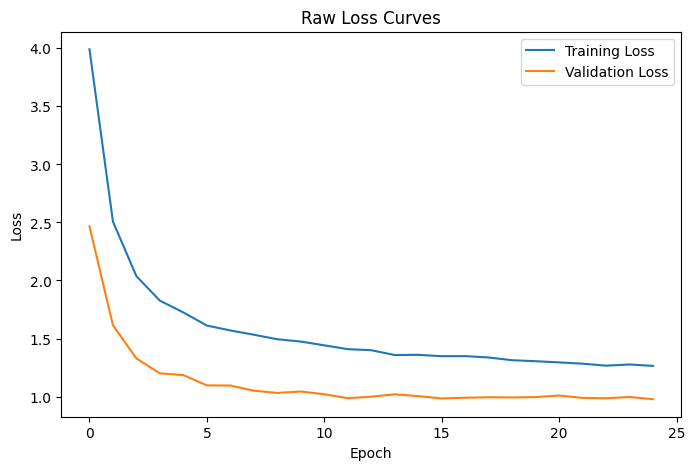

In [ ]:
fig = plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Raw Loss Curves')
plt.legend()
plt.show()
fig.savefig("results_figures/51520_loss.jpg")

In [39]:
train_loss = np.array(train_loss)
cum_train_loss = np.cumsum(train_loss)
avg_train_loss = cum_train_loss / np.arange(1, len(train_loss) + 1)

val_loss = np.array(val_loss)
cum_val_loss = np.cumsum(val_loss)
avg_val_loss = cum_val_loss / np.arange(1, len(val_loss) + 1)

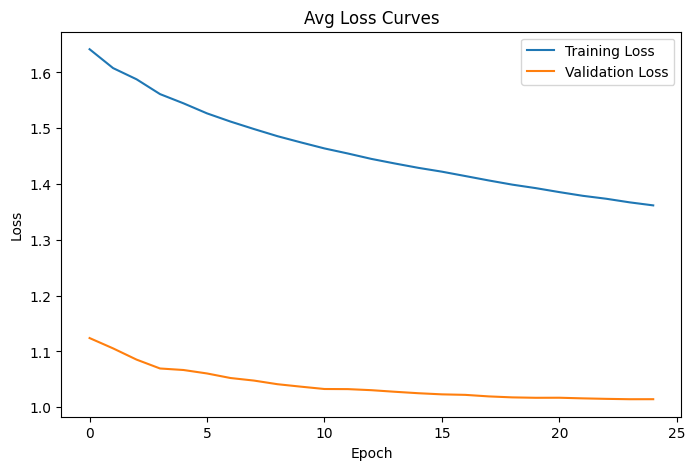

In [72]:
fig = plt.figure(figsize=(8,5))
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Avg Loss Curves')
plt.legend()
plt.show()
fig.savefig("results_figures/51520_avg_loss.jpg")

In [49]:
model_state = cnn.state_dict()

torch.save(model_state, "model_1.0")

In [ ]:
# load trained model from storage
state_dict = torch.load("model_1.0", map_location=device)
cnn.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
predictions = evaluate(cnn, test_loader)

FileNotFoundError: [Errno 2] No such file or directory: 'data/test\\000bec180eb18c7604dcecc8fe0dba07.jpg'